In [ ]:
#https://medium.com/sfu-cspmp/xgboost-a-deep-dive-into-boosting-f06c9c41349
#very good reference

## go over the categorical solutions

In [24]:
import pandas as pd
import numpy as np

In [25]:
df_master=pd.read_csv("df_master.csv", index_col=0)

In [26]:
df_master.head()

,Date,Open,High,Low,Close*,Adj Close**,Volume,percentage,z-score,Label,...,Gain,Loss,AVG_Gain,AVG_Loss,RS,RSI,obv,VAO,Positive,VolumePositive
0,2008-09-17,11056.58,11057.31,10595.90,10609.66,10609.66,463200000.0,-0.040633,-3.403907,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,-1.004889e+11,False,False
1,2008-09-18,10609.01,11076.44,10459.44,11019.69,11019.69,488060000.0,0.038647,-1.564634,1.0,...,410.03,0.00,NaN,NaN,NaN,NaN,4.880600e+08,1.228691e+11,True,True
2,2008-09-19,11027.51,11483.05,11026.70,11388.44,11388.44,655110000.0,0.033463,0.011810,1.0,...,368.75,0.00,NaN,NaN,NaN,NaN,1.143170e+09,8.749977e+10,True,True
3,2008-09-22,11394.42,11394.58,10992.20,11015.69,11015.69,213210000.0,-0.032731,-1.549244,0.0,...,0.00,372.75,NaN,NaN,NaN,NaN,9.299600e+08,-3.788742e+10,False,False
4,2008-09-23,11015.69,11143.21,10833.94,10854.17,10854.17,204480000.0,-0.014663,-2.108707,0.0,...,0.00,161.52,NaN,NaN,NaN,NaN,7.254800e+08,-2.748313e+10,False,False


In [33]:
df_master.head()
df_master['percentage_yesterday']=df_master['percentage']

In [86]:
# lets first shifting
mask = ~(df_master.columns.isin(['Date','Open', 'High', 'Low', 'Close*', 'Adj Close**', 'percentage', 'Label']))

cols_to_shift = df_master.columns[mask]

df_master[cols_to_shift] = df_master.loc[:,mask].shift(1)


In [87]:
df_master.head() #look at the positive columsn, we are using yesterday's information

,Date,Open,High,Low,Close*,Adj Close**,Volume,percentage,z-score,Label,...,Loss,AVG_Gain,AVG_Loss,RS,RSI,obv,VAO,Positive,VolumePositive,percentage_yesterday
0,2008-09-17,11056.58,11057.31,10595.90,10609.66,10609.66,NaN,-0.040633,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN
1,2008-09-18,10609.01,11076.44,10459.44,11019.69,11019.69,NaN,0.038647,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.040633
2,2008-09-19,11027.51,11483.05,11026.70,11388.44,11388.44,463200000.0,0.033463,-3.403907,1.0,...,NaN,NaN,NaN,NaN,NaN,0.000000e+00,-1.004889e+11,False,False,0.038647
3,2008-09-22,11394.42,11394.58,10992.20,11015.69,11015.69,488060000.0,-0.032731,-1.564634,1.0,...,0.0,NaN,NaN,NaN,NaN,4.880600e+08,1.228691e+11,True,True,0.033463
4,2008-09-23,11015.69,11143.21,10833.94,10854.17,10854.17,655110000.0,-0.014663,0.011810,0.0,...,0.0,NaN,NaN,NaN,NaN,1.143170e+09,8.749977e+10,True,True,-0.032731


# XGBoost Classification

In [88]:
import xgboost as xgb


In [89]:
model=xgb.XGBClassifier()

In [63]:
from sklearn.model_selection import train_test_split


In [90]:
X=df_master[['significance', 'sentiment', '30_SMA', '50_SMA', '200_SMA', 'EMA', 'Upper Bollinger Band', 'Lower Bollinger Band', 'stoch_k', 'stoch_d', 'RSI', 'obv', 'VAO', 'percentage_yesterday']]

In [91]:
y= df_master['percentage'].apply(lambda x: 2 if x > 0 else 1 if x < 0 else 0)
#positive is a 2, 1 is a negative and 0 is o
y

0       1
1       2
2       2
3       1
4       1
       ..
1954    1
1955    2
1956    2
1957    2
1958    2
Name: percentage, Length: 1959, dtype: int64

In [92]:
import seaborn as sns

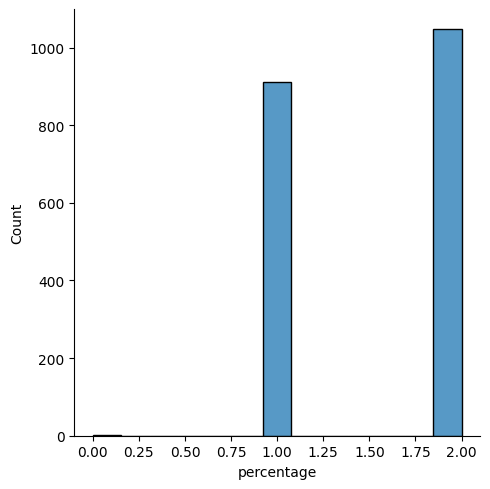

In [93]:
sns.displot(y)

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2)

In [95]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1371 entries, 1048 to 1192
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   significance          1369 non-null   float64
 1   sentiment             1369 non-null   float64
 2   30_SMA                1369 non-null   float64
 3   50_SMA                1369 non-null   float64
 4   200_SMA               1369 non-null   float64
 5   EMA                   1224 non-null   float64
 6   Upper Bollinger Band  1331 non-null   float64
 7   Lower Bollinger Band  1331 non-null   float64
 8   stoch_k               1224 non-null   float64
 9   stoch_d               1187 non-null   float64
 10  RSI                   1330 non-null   float64
 11  obv                   1369 non-null   float64
 12  VAO                   1369 non-null   float64
 13  percentage_yesterday  1370 non-null   float64
dtypes: float64(14)
memory usage: 160.7 KB


In [96]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [97]:
prediction=model.predict(X_test)

In [52]:
from sklearn.metrics import accuracy_score


In [117]:
accuracy_score(y_test, prediction)

ValueError: Length of values (588) does not match length of index (1959)

## Grid Search CV ##

In [100]:
param_grid = {
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "scale_pos_weight": [1, 3, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}


In [101]:
from sklearn.model_selection import GridSearchCV


In [75]:
# Init classifier
xgb_cl = xgb.XGBClassifier(objective="multi:softmax")



[22:05:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:05:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:05:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:05:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:05:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:05:02] WARNING: /Users/runner/work/xgboost/xgb

/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 471, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, *

: { "scale_pos_weight" } are not used.

[22:05:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:05:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:05:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:05:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:05:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:05:07]

nc(y, y_pred, **scoring_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_ranking.py", line 619, in roc_auc_score
    raise ValueError("multi_class must be in ('ovo', 'ovr')")
ValueError: multi_class must be in ('ovo', 'ovr')

  warnings.warn(
/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py"

[22:05:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:05:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:05:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:05:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:05:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:05:02] WARNING: /Users/runner/work/xgboost/xgb

/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 471, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, *

[22:05:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:05:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:05:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:05:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:05:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:05:01] WARNING: /Users/runner/work/xgboost/xgb

/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 471, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, *

[22:05:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:05:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:05:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:05:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:05:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:05:02] WARNING: /Users/runner/work/xgboost/xgb

/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 471, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, *

In [76]:
# Init Grid Search
grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=3, scoring="roc_auc")


In [77]:
_=grid_cv.fit(X_train, y_train)


/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 471, in _score
    retur

ValueError: multi_class must be in ('ovo', 'ovr')

  warnings.warn(
/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 471, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/utils/

/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 471, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, *

/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_val

/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 471, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, *

/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_val

/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_val

/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 471, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, *

/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:976: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan

[22:11:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:10:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:10:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:10:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:10:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:10:40] WARNING: /Users/runner/work/xgboost/xgb

/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_val

ner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:10:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:10:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:10:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:10:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:10:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp

set to nan. Details: 
Traceback (most recent call last):
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/louisalu/Documents/04

    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "

[22:10:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:10:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:10:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:10:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:10:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:10:40] WARNING: /Users/runner/work/xgboost/xgb

/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 471, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, *

gboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:11:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:11:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:11:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:11:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:11:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10

pported

  warnings.warn(
/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 471, in _score
    return self._sign * self._score_func(y, y_pred, **scoring_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/utils/_param_validation.py", line 211, in wrappe

[22:10:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:10:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:10:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:10:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:10:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:10:40] WARNING: /Users/runner/work/xgboost/xgb

/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/sklearn/model_selection/_val

[22:10:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:10:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:10:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:10:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:10:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[22:10:40] WARNING: /Users/runner/work/xgboost/xgb

In [62]:
grid_cv.best_score_

nan

In [102]:
y= df_master['percentage'].apply(lambda x: 1 if x >= 0 else 0 )
#positive 1 otherwise 0
y

0       0
1       1
2       1
3       0
4       0
       ..
1954    0
1955    1
1956    1
1957    1
1958    1
Name: percentage, Length: 1959, dtype: int64

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2)

In [104]:
xgb_cl = xgb.XGBClassifier(objective="binary:logistic")



In [105]:
grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=3, scoring="roc_auc")
_=grid_cv.fit(X_train, y_train)

In [106]:
grid_cv.best_score_

0.5471479021918545

In [107]:
grid_cv.best_params_

{'colsample_bytree': 0.5,
 'gamma': 0.25,
 'learning_rate': 0.1,
 'max_depth': 7,
 'reg_lambda': 0,
 'scale_pos_weight': 3,
 'subsample': 0.8}

In [109]:
param_grid = {
    "max_depth": [5, 7, 9, 11],
    "learning_rate": [0.01, 0.05, 0.07, 0.1],
    "gamma":  [0.25],
    "reg_lambda": [0, 0.2, 0.4],
    "scale_pos_weight": [3],
    "subsample": [0.8],
    "colsample_bytree": [0.5],
}



grid_cv_2 = GridSearchCV(xgb_cl, param_grid, 
                         cv=3, scoring="roc_auc", n_jobs=-1)

_ = grid_cv_2.fit(X_train, y_train)

grid_cv_2.best_score_


0.5471479021918545

In [110]:
grid_cv_2.best_params_

{'colsample_bytree': 0.5,
 'gamma': 0.25,
 'learning_rate': 0.1,
 'max_depth': 7,
 'reg_lambda': 0,
 'scale_pos_weight': 3,
 'subsample': 0.8}

In [111]:
final_cl = xgb.XGBClassifier(
    **grid_cv_2.best_params_,
    objective="binary:logistic",
)


In [112]:
from sklearn.metrics import roc_auc_score


In [113]:
final_cl.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.25, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [114]:
prediction = final_cl.predict(X_test)


In [115]:
roc_auc_score(y_test, prediction)

0.48938723644578314

In [116]:
accuracy_score(y_test, prediction)

0.5289115646258503

In [ ]:
df_

## Classes

In [2]:
number = 69


In [4]:
number + 2

71

In [5]:
type(number)

int

In [15]:
def double(number):
    return number * 2

class mynumberclass():
    def __init__(self, number: int):  
        # dunder: https://mathspp.com/blog/pydonts/dunder-methods#:~:text=In%20Python%2C%20dunder%20methods%20are,__%20or%20__add__%20.
        self.value = number

    def double(self):
        self.value *= 2
        return self.value
        
    

In [8]:
double(3)

6

In [105]:
n = mynumberclass(3) #instantiate python class
n.value

3

In [93]:
n.double() #The value carry through the class

192

In [106]:
# you can pass a class vairables
class MyClass:
    class_varaible="I am a class Varaible"


In [110]:
x=MyClass()
print (x.class_varaible)

I am a class Varaible


In [95]:
dir('im a string')

['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getnewargs__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmod__',
 '__rmul__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'capitalize',
 'casefold',
 'center',
 'count',
 'encode',
 'endswith',
 'expandtabs',
 'find',
 'format',
 'format_map',
 'index',
 'isalnum',
 'isalpha',
 'isascii',
 'isdecimal',
 'isdigit',
 'isidentifier',
 'islower',
 'isnumeric',
 'isprintable',
 'isspace',
 'istitle',
 'isupper',
 'join',
 'ljust',
 'lower',
 'lstrip',
 'maketrans',
 'partition',
 'replace',
 'rfind',
 'rindex',
 'rjust',
 'rpartition',
 'rsplit',
 'rstrip',
 'split',
 'splitlines',
 'startswith',
 'strip',
 'swapcase',
 'title',
 'translate',
 'upper',


In [96]:
def fibonacci(sequence_length):
    "Return the Fibonacci sequence of length *sequence_length*"
    sequence = [0,1]
    if sequence_length < 1:
        print("Fibonacci sequence only defined for length 1 or greater")
        return
    if 0 < sequence_length < 3:
        return sequence[:sequence_length]
    for i in range(2,sequence_length): 
        sequence.append(sequence[i-1]+sequence[i-2])
    return sequence

In [100]:
class FibSequence():
    def __init__(self, sequence_length): 
        if sequence_length == None:
            self.sequence = [0, 1]
        else:
            self.sequence = [0,1]
            if sequence_length < 1:
                self.sequence = [0, 1]
            if 0 < sequence_length < 3:
                self.sequence = self.sequence[:sequence_length]
            for i in range(2,sequence_length): 
                self.sequence.append(self.sequence[i-1]+self.sequence[i-2])
                      

    def next(self) -> int:
        next_value = sum(self.sequence[-2:])
        self.sequence.append(next_value)
        return next_value

In [101]:
my_sequence=FibSequence(10)

In [102]:
my_sequence.sequence

[0, 1, 1, 2, 3, 5, 8, 13, 21, 34]

In [103]:
my_sequence.next()

55

In [104]:
my_sequence.sequence

[0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55]

In [81]:
class FibSequence():
    def __init__(self, initial_sequence=[0,1]):  # do not initiate the class with a list, which
        self.sequence = initial_sequence

    def next(self) -> int:
        next_value = sum(self.sequence[-2:])
        self.sequence.append(next_value)
        return next_value


In [82]:
my_sequence=FibSequence()

In [88]:
my_sequence.next()

3

In [89]:
my_sequence.sequence

[0, 1, 1, 2, 3]

In [90]:
my_sequence2=FibSequence()

In [92]:
my_sequence2.sequence  
#because list is shared across and it is a mutable object, dangerous to use all of it in the same mutable object

[0, 1, 1, 2, 3]

## Inheritance

In [ ]:
class mynumberclass():
    def __init__(self, number: int):  
        # dunder: https://mathspp.com/blog/pydonts/dunder-methods#:~:text=In%20Python%2C%20dunder%20methods%20are,__%20or%20__add__%20.
        self.value = number

    def double(self):
        self.value *= 2
        return self.value


    

In [114]:
number=mynumberclass(4)
number.double()

8

In [115]:
number+5

TypeError: unsupported operand type(s) for +: 'mynumberclass' and 'int'

In [124]:
class mynumberclass(int): # taking from the parents class, no need for initi
    def double(self): 
        return self*2  #self is the same as int * 2

In [122]:
number2=mynumberclass(4)


In [123]:
number2.double()

8

In [125]:
number2 + 5 #because we are taking the int value

9

## Polymorphism

In [127]:
dir(int)

['__abs__',
 '__add__',
 '__and__',
 '__bool__',
 '__ceil__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floor__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getnewargs__',
 '__gt__',
 '__hash__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__le__',
 '__lshift__',
 '__lt__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdivmod__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',
 '__rlshift__',
 '__rmod__',
 '__rmul__',
 '__ror__',
 '__round__',
 '__rpow__',
 '__rrshift__',
 '__rshift__',
 '__rsub__',
 '__rtruediv__',
 '__rxor__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__trunc__',
 '__xor__',
 'as_integer_ratio',
 'bit_length',
 'conjugate',
 'denominator',
 'from_bytes',
 'imag',
 'numerator',
 'real',
 'to_bytes']

In [130]:
class mynumberclass(int): # taking from the parents class, no need for initi
    
    def double(self): 
        return self*2  #self is the same as int * 2

    def __add__(self, value):
        return self * value

In [129]:
my_number=mynumberclass(4)

In [131]:
my_number + 3  # now it is *3

12

lets go over the backtesting on the presentation

## Backtesting

In [3]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
import pandas as pd
import numpy as np


In [4]:
df_price = (
    # Load file
    pd.read_csv('dowj_price_indicators.csv', index_col=0)

    # Rename and filter columns
    .rename(columns={'Close*':'Close'})
    [['Date', 'Open', 'High', 'Low', 'Close']]

    # Parse dates, sort by them and set as index
    .assign(Date = lambda df: pd.to_datetime(df.Date))
    .sort_values('Date')
    .set_index('Date', drop=True)
)

In [5]:
df_predictions = (
    # Load file
    pd.read_csv('prediction_output.csv', index_col=0)

    # Parse dates, sort by them and set as index
    .assign(Date = lambda df: pd.to_datetime(df.Date))
    .sort_values('Date')
    .set_index('Date', drop=True)
)

In [6]:
# Predictions includes only testing data so the resulting df has only that as well
df_price_and_predictions = df_predictions.join(df_price)
df_price_and_predictions

,iterate_prediction,grid_prediction,random_prediction,Open,High,Low,Close
Date,,,,,,,
2014-03-05,-0.000488,0.000614,-0.002610,16395.88,16406.55,16343.96,16360.18
2014-03-06,0.004805,0.002387,-0.000320,16360.56,16450.17,16360.56,16421.89
2014-03-07,0.001993,0.002387,-0.000598,16424.53,16505.70,16398.86,16452.72
2014-03-10,0.003717,0.001717,-0.001000,16453.10,16453.10,16334.20,16418.68
2014-03-11,-0.001528,0.001017,-0.000465,16419.39,16460.33,16325.17,16351.25
...,...,...,...,...,...,...,...
2016-06-27,0.035532,0.005833,0.004592,17355.21,17355.21,17063.08,17140.24
2016-06-28,0.022988,0.012130,0.011819,17190.51,17409.72,17190.51,17409.72
2016-06-29,0.026804,0.005521,0.003258,17456.02,17704.51,17456.02,17694.68


In [7]:
def identity(x):
    '''Identity, this is hack because we already precomputed'''
    return x

class PredictionStrat(Strategy):
    """
    Open a long position when data.prediction is >= zero (closes short position).
    Open a short position otherwise (closes long position).
    Requires exclusive_orders=True.
    """

    def init(self):
        self.prediction = self.I(identity, self.data.prediction)
        
    def next(self):
        current_prediction = self.prediction[-1]
        if current_prediction >= 0:
            self.buy()
        else:
            self.sell()




In [8]:
def backtest(df_input: pd.DataFrame, prediction_col: str) -> Backtest:
    """Renames prediction_col to "prediction" and backtests PredictionStrategy with it."""

    # Rename prediction_col to used_col in PredictionStrategy
    _df_input = df_input.rename(columns={prediction_col:'prediction'}, inplace=False)

    # Creates backtest obj, runs and plots
    bt = Backtest(_df_input, PredictionStrat, exclusive_orders=True, cash=100_000_000, commission=0.0001)
    print(bt.run())
    bt.plot()


In [9]:
backtest(df_price_and_predictions, 'grid_prediction')

Start                     2014-03-05 00:00:00
End                       2016-07-01 00:00:00
Duration                    849 days 00:00:00
Exposure Time [%]                   99.659864
Equity Final [$]              88548813.678411
Equity Peak [$]              103976606.466917
Return [%]                         -11.451186
Buy & Hold Return [%]                9.713768
Return (Ann.) [%]                   -5.078622
Volatility (Ann.) [%]               13.055845
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -18.635741
Avg. Drawdown [%]                   -6.448746
Max. Drawdown Duration      434 days 00:00:00
Avg. Drawdown Duration      120 days 00:00:00
# Trades                                  586
Win Rate [%]                        50.341297
Best Trade [%]                       3.876062
Worst Trade [%]                     -3.518085
Avg. Trade [%]                    

In [10]:
backtest(df_price_and_predictions, 'random_prediction')

Start                     2014-03-05 00:00:00
End                       2016-07-01 00:00:00
Duration                    849 days 00:00:00
Exposure Time [%]                   99.659864
Equity Final [$]             123450361.097815
Equity Peak [$]              124007807.678584
Return [%]                          23.450361
Buy & Hold Return [%]                9.713768
Return (Ann.) [%]                    9.448802
Volatility (Ann.) [%]               15.054176
Sharpe Ratio                         0.627653
Sortino Ratio                        1.012692
Calmar Ratio                         0.803497
Max. Drawdown [%]                  -11.759599
Avg. Drawdown [%]                   -2.843082
Max. Drawdown Duration      497 days 00:00:00
Avg. Drawdown Duration       43 days 00:00:00
# Trades                                  586
Win Rate [%]                        51.706485
Best Trade [%]                       3.876062
Worst Trade [%]                     -3.518085
Avg. Trade [%]                    

In [11]:
backtest(df_price_and_predictions, 'iterate_prediction')

Start                     2014-03-05 00:00:00
End                       2016-07-01 00:00:00
Duration                    849 days 00:00:00
Exposure Time [%]                   99.659864
Equity Final [$]              88121032.618473
Equity Peak [$]              104368216.912157
Return [%]                         -11.878967
Buy & Hold Return [%]                9.713768
Return (Ann.) [%]                   -5.275423
Volatility (Ann.) [%]               12.898538
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -23.519957
Avg. Drawdown [%]                   -5.626557
Max. Drawdown Duration      567 days 00:00:00
Avg. Drawdown Duration      106 days 00:00:00
# Trades                                  586
Win Rate [%]                        48.976109
Best Trade [%]                       2.442342
Worst Trade [%]                      -3.89684
Avg. Trade [%]                    

In [12]:
class BollingerStrat(Strategy):
    window_len = 50
    n_stds = 2

    def init(self, n_stds=None, window_len=None):
        rolling = self.data.df.Close.rolling(self.window_len)
        upper_bollinger = rolling.mean() + self.n_stds * rolling.std()
        lower_bollinger = rolling.mean() - self.n_stds * rolling.std()
        self.upper_bollinger = self.I(identity, upper_bollinger)
        self.lower_bollinger = self.I(identity, lower_bollinger)
        self.Close = self.I(identity, self.data.Close)

    def next(self):
        if self.Close >= self.upper_bollinger:
            self.buy()
        elif self.Close <= self.lower_bollinger:
            self.sell()

In [13]:
bt = Backtest(df_price_and_predictions, BollingerStrat, cash=100_000_000, exclusive_orders=True)
print(bt.run())
bt.plot()

Start                     2014-03-05 00:00:00
End                       2016-07-01 00:00:00
Duration                    849 days 00:00:00
Exposure Time [%]                   88.945578
Equity Final [$]                  74455656.68
Equity Peak [$]                  101772849.28
Return [%]                         -25.544343
Buy & Hold Return [%]                9.713768
Return (Ann.) [%]                  -11.875024
Volatility (Ann.) [%]                12.52305
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -26.866896
Avg. Drawdown [%]                    -7.45602
Max. Drawdown Duration      716 days 00:00:00
Avg. Drawdown Duration      188 days 00:00:00
# Trades                                   52
Win Rate [%]                        63.461538
Best Trade [%]                       3.508437
Worst Trade [%]                    -10.668282
Avg. Trade [%]                    

Row(id='3547', ...)

In [14]:
window_lens = list(range(5,105,5))
n_stds = list(np.linspace(0.5, 4, 15))

In [15]:
n_stds

[0.5,
 0.75,
 1.0,
 1.25,
 1.5,
 1.75,
 2.0,
 2.25,
 2.5,
 2.75,
 3.0,
 3.25,
 3.5,
 3.75,
 4.0]

In [16]:
from backtesting.lib import plot_heatmaps

bt = Backtest(df_price_and_predictions, BollingerStrat, cash=100_000_000, exclusive_orders=True)

results, heatmap = bt.optimize(window_len=window_lens, n_stds=n_stds, maximize='Return [%]', return_heatmap=True)

/Users/louisalu/Documents/04WSP/venv/lib/python3.8/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


In [17]:
plot_heatmaps(heatmap)

Column(id='3838', ...)

In [18]:
results._strategy

<Strategy BollingerStrat(window_len=10,n_stds=2.0)>

In [19]:
class OptimizedBollingerStrat(BollingerStrat):
    n_stds = 2
    window_len = 10

In [20]:
bt = Backtest(df_price_and_predictions, OptimizedBollingerStrat, cash=100_000_000, exclusive_orders=True)
print(bt.run())
bt.plot()

Start                     2014-03-05 00:00:00
End                       2016-07-01 00:00:00
Duration                    849 days 00:00:00
Exposure Time [%]                   96.768707
Equity Final [$]                 106866828.11
Equity Peak [$]                  117666941.59
Return [%]                           6.866828
Buy & Hold Return [%]                9.713768
Return (Ann.) [%]                    2.887177
Volatility (Ann.) [%]               14.298876
Sharpe Ratio                         0.201916
Sortino Ratio                        0.298915
Calmar Ratio                         0.212784
Max. Drawdown [%]                  -13.568565
Avg. Drawdown [%]                   -2.670105
Max. Drawdown Duration      540 days 00:00:00
Avg. Drawdown Duration       44 days 00:00:00
# Trades                                   34
Win Rate [%]                        58.823529
Best Trade [%]                       5.708328
Worst Trade [%]                     -5.614752
Avg. Trade [%]                    

Row(id='4318', ...)

lets do an exercise for MA optimization practice